In [1]:
import pandas as pd 
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import tqdm

In [2]:
protein_sequences_labelled = pd.read_csv("filtered_labelled_protein_sequences.tsv", sep = "\t")

In [3]:
protein_seq_by_type = protein_sequences_labelled.groupby('classification')['concatenated_sequence'].apply(list).to_dict()

In [4]:
all_sequences = ''.join(protein_sequences_labelled['concatenated_sequence'].values)
all_characters = ["PAD"] + list(set(all_sequences))
character_index = {char: all_characters.index(char) for char in all_characters}
n_characters = len(all_characters)
all_protein_classifications = protein_sequences_labelled['classification'].unique().tolist()
n_classifications = len(all_protein_classifications)

In [5]:
def polypeptide_to_indices(polypeptide):
    return torch.tensor([character_index[AA] for AA in polypeptide], dtype=torch.long)

In [6]:
class ProteinDataset(Dataset):
    def __init__(self, protein_sequences_labelled, transform=None, target_transform=None):
        self.protein_sequences_labelled = protein_sequences_labelled
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.protein_sequences_labelled)
    
    def __getitem__(self, idx):
        row = self.protein_sequences_labelled.iloc[idx]
        protein_sequence = row['concatenated_sequence']
        label = row['classification']
       
        if self.transform:
            sequence_tensor = self.transform(protein_sequence)
        else:
            sequence_tensor = polypeptide_to_indices(protein_sequence)

        if self.target_transform:
            label = self.target_transform(label)
        else:
            label = torch.tensor([all_protein_classifications.index(label)], dtype=torch.long)

        return sequence_tensor, label

In [7]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence

def collate_fn(batch):
    sequences, labels = zip(*batch)
    
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=character_index["PAD"])
    
    stacked_labels = torch.cat(labels) 

    return padded_sequences, stacked_labels

In [8]:
train_data, temp_data = train_test_split(
    protein_sequences_labelled, 
    test_size=0.2,
    stratify=protein_sequences_labelled['classification']  
)

test_data, val_data = train_test_split(
    temp_data, 
    test_size=0.5,  
    stratify=temp_data['classification']
)

train_dataset = ProteinDataset(train_data)
test_dataset = ProteinDataset(test_data)
val_dataset = ProteinDataset(val_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

print("Training dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Training dataset size: 80943
Validation dataset size: 10118
Test dataset size: 10118


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_layers, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        self.lstm = nn.LSTM(embedding_dim,
                            hidden_size,
                            num_layers=num_layers,
                            batch_first=True) 
        self.fc = nn.Linear(hidden_size, output_size)  # No softmax - using cross-entropy loss

    def forward(self, x):
        x = self.embedding(x)  
        out, (hidden, cell) = self.lstm(x)  
        out = out[:, -1, :]  # Get the output of the last time step
        out = self.fc(out)  
        return out

In [10]:
lstm = LSTM(vocab_size = n_characters,
            embedding_dim=48,
            num_layers=3,
            hidden_size = 64,
            output_size = n_classifications).to(device)

In [11]:
import matplotlib.pyplot as plt
from tqdm import tqdm

def train(dataloader, model, criterion, optimizer, num_epochs):
    model.train()  
    all_losses = []  

    for epoch in range(num_epochs):
        total_loss = 0.0
        epoch_losses = []  
        with tqdm(total=len(dataloader), desc="Training Progress", unit='batch') as pbar:
            for line_tensor, category_tensor in dataloader:
                optimizer.zero_grad()

                line_tensor = line_tensor.to(device).contiguous()
                category_tensor = category_tensor.to(device)
                output = model(line_tensor)
                
                loss = criterion(output, category_tensor)
                epoch_losses.append(loss.item())  # Save batch loss for this epoch
                
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

                pbar.set_postfix(loss=loss.item())
                pbar.update(1) 

        all_losses.append(sum(epoch_losses) / len(epoch_losses))
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {all_losses[-1]}")

    return all_losses  

In [12]:
num_epochs = 30  # Set the number of epochs
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)

losses = train(train_loader, lstm, criterion=criterion, optimizer=optimizer, num_epochs=num_epochs)

Training Progress: 100%|██████████| 2530/2530 [01:28<00:00, 28.53batch/s, loss=3.35]


Epoch 1/30, Loss: 2.8991378729522466


Training Progress: 100%|██████████| 2530/2530 [01:26<00:00, 29.20batch/s, loss=2.89]


Epoch 2/30, Loss: 2.8867994425325056


Training Progress: 100%|██████████| 2530/2530 [01:29<00:00, 28.38batch/s, loss=3.12]


Epoch 3/30, Loss: 2.882269414988431


Training Progress: 100%|██████████| 2530/2530 [01:29<00:00, 28.30batch/s, loss=2.63]


Epoch 4/30, Loss: 2.8796736603197846


Training Progress: 100%|██████████| 2530/2530 [01:25<00:00, 29.63batch/s, loss=2.79]


Epoch 5/30, Loss: 2.881590812385318


Training Progress: 100%|██████████| 2530/2530 [01:27<00:00, 28.87batch/s, loss=2.73]


Epoch 6/30, Loss: 2.879559151834179


Training Progress: 100%|██████████| 2530/2530 [01:28<00:00, 28.64batch/s, loss=2.54]


Epoch 7/30, Loss: 2.8792922475121236


Training Progress: 100%|██████████| 2530/2530 [01:29<00:00, 28.36batch/s, loss=2.96]


Epoch 8/30, Loss: 2.8766074734714193


Training Progress: 100%|██████████| 2530/2530 [01:29<00:00, 28.15batch/s, loss=3.1] 


Epoch 9/30, Loss: 2.877407997587453


Training Progress: 100%|██████████| 2530/2530 [01:26<00:00, 29.08batch/s, loss=2.66]


Epoch 10/30, Loss: 2.8291822950830574


Training Progress: 100%|██████████| 2530/2530 [01:26<00:00, 29.20batch/s, loss=2.86]


Epoch 11/30, Loss: 2.7874437872128994


Training Progress: 100%|██████████| 2530/2530 [01:27<00:00, 28.91batch/s, loss=2.97]


Epoch 12/30, Loss: 2.7381178989240773


Training Progress: 100%|██████████| 2530/2530 [01:25<00:00, 29.53batch/s, loss=2.53]


Epoch 13/30, Loss: 2.6473900288461225


Training Progress: 100%|██████████| 2530/2530 [01:30<00:00, 28.01batch/s, loss=2.63]


Epoch 14/30, Loss: 2.446380153710663


Training Progress: 100%|██████████| 2530/2530 [01:29<00:00, 28.24batch/s, loss=2.96]


Epoch 15/30, Loss: 2.224704315775468


Training Progress: 100%|██████████| 2530/2530 [01:27<00:00, 28.88batch/s, loss=2.3] 


Epoch 16/30, Loss: 2.1042729951176247


Training Progress: 100%|██████████| 2530/2530 [01:28<00:00, 28.66batch/s, loss=2.74]


Epoch 17/30, Loss: 2.0129740453991496


Training Progress: 100%|██████████| 2530/2530 [01:25<00:00, 29.47batch/s, loss=2.11]


Epoch 18/30, Loss: 1.940197042655568


Training Progress: 100%|██████████| 2530/2530 [01:26<00:00, 29.32batch/s, loss=2.4] 


Epoch 19/30, Loss: 1.8947631322819254


Training Progress: 100%|██████████| 2530/2530 [01:24<00:00, 29.79batch/s, loss=1.35] 


Epoch 20/30, Loss: 1.833541851269869


Training Progress: 100%|██████████| 2530/2530 [01:26<00:00, 29.26batch/s, loss=1.54] 


Epoch 21/30, Loss: 1.7912595690239088


Training Progress: 100%|██████████| 2530/2530 [01:25<00:00, 29.76batch/s, loss=1.8]  


Epoch 22/30, Loss: 1.7539103022677154


Training Progress: 100%|██████████| 2530/2530 [01:27<00:00, 29.03batch/s, loss=1.7]  


Epoch 23/30, Loss: 1.715794372911981


Training Progress: 100%|██████████| 2530/2530 [01:29<00:00, 28.24batch/s, loss=1.92] 


Epoch 24/30, Loss: 1.8835239665545964


Training Progress: 100%|██████████| 2530/2530 [01:26<00:00, 29.25batch/s, loss=2.38] 


Epoch 25/30, Loss: 1.692350140225746


Training Progress: 100%|██████████| 2530/2530 [01:27<00:00, 28.94batch/s, loss=1.35] 


Epoch 26/30, Loss: 1.6547812235685204


Training Progress: 100%|██████████| 2530/2530 [01:29<00:00, 28.32batch/s, loss=2.12] 


Epoch 27/30, Loss: 1.701232616585705


Training Progress: 100%|██████████| 2530/2530 [01:27<00:00, 29.06batch/s, loss=1.91] 


Epoch 28/30, Loss: 1.6119616355113833


Training Progress: 100%|██████████| 2530/2530 [01:31<00:00, 27.58batch/s, loss=2.01] 


Epoch 29/30, Loss: 1.5988684461286418


Training Progress: 100%|██████████| 2530/2530 [01:30<00:00, 27.90batch/s, loss=1.77] 

Epoch 30/30, Loss: 1.5730982871866037


In [ ]:
# torch.save(lstm.state_dict(), "lstm_weights_deep.pth") #kills the kernel for some reason. Ram limitations?

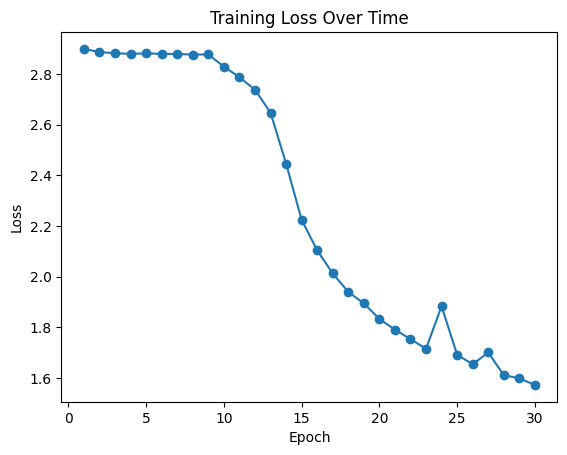

In [13]:
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def create_confusion_matrix(model, data_loader, device):
    model.eval()
    
    true_labels = []
    predicted_labels = []
    
    with torch.no_grad():
        for sequences, labels in data_loader:
            sequences = sequences.to(device).contiguous()
            labels = labels.to(device)
            
            outputs = model(sequences)
            
            _, predicted = torch.max(outputs, 1)
            
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())
    
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    
    cm = confusion_matrix(true_labels, predicted_labels)
    
    return cm, true_labels, predicted_labels

confusion_mat, true_labels, predicted_labels = create_confusion_matrix(lstm, test_loader, device)

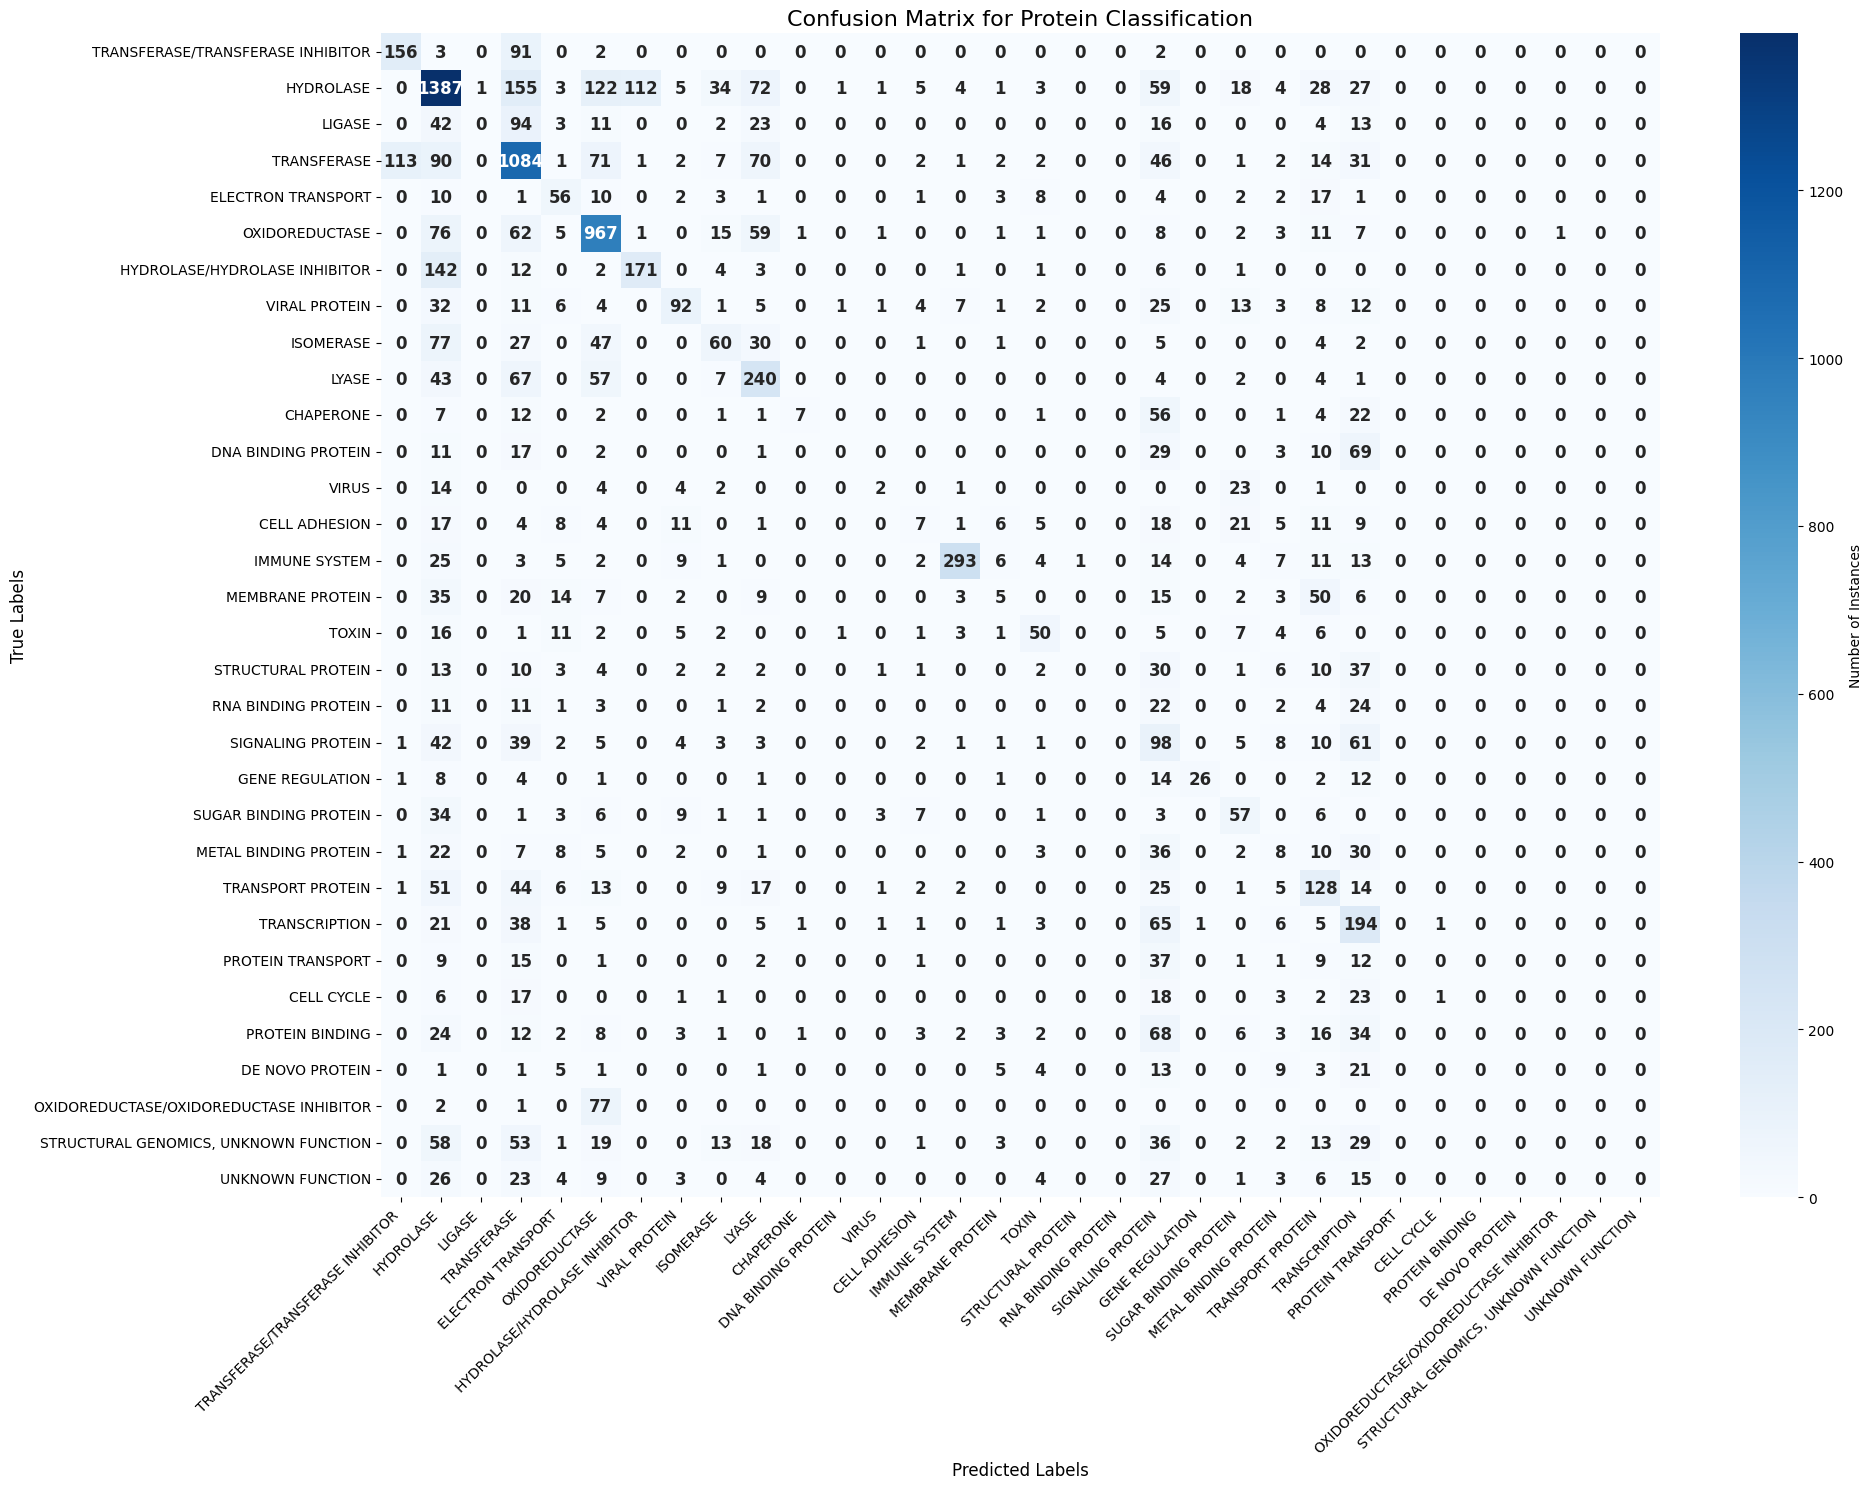

In [15]:
plt.figure(figsize=(20, 15)) 
sns.heatmap(confusion_mat, 
            annot=True,  
            fmt='d',     
            cmap='Blues', 
            xticklabels=all_protein_classifications, 
            yticklabels=all_protein_classifications,
            annot_kws={'size': 12, 'weight':'bold'},  
            cbar_kws={'label': 'Number of Instances'})

plt.title('Confusion Matrix for Protein Classification', fontsize=16)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.xticks(rotation=45, ha='right')  
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [16]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

def calculate_classification_metrics(true_labels, predicted_labels):    
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)
    
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        true_labels, predicted_labels, average='macro'
    )
    
    return macro_precision, macro_recall, macro_f1

# Calculate metrics
precision, recall, f1 = calculate_classification_metrics(true_labels, predicted_labels)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
precision

0.309755926580869

In [18]:
recall

0.26509611385362053

In [19]:
f1

0.2583458818125581

In [20]:
from sklearn.metrics import accuracy_score
accuracy_score(true_labels, predicted_labels)

0.502965012848389

In [21]:
TP = np.trace(confusion_mat)  # Sum of diagonal elements
FP = confusion_mat.sum(axis=0) - np.diag(confusion_mat)  # Column sums minus diagonal
FN = confusion_mat.sum(axis=1) - np.diag(confusion_mat)  # Row sums minus diagonal
TN = confusion_mat.sum() - (TP + FP.sum() + FN.sum())  # Total minus other metrics

# Results
aggregate_results = {
    "True Positives (TP)": TP,
    "False Positives (FP)": FP.sum(),
    "False Negatives (FN)": FN.sum(),
    "True Negatives (TN)": TN
}

# Print results
print(aggregate_results)

{'True Positives (TP)': 5089, 'False Positives (FP)': 5029, 'False Negatives (FN)': 5029, 'True Negatives (TN)': -5029}


In [22]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np

def evaluate_model(model, dataloader, criterion):
    model.eval()  
    all_labels = []
    all_predictions = []

    with torch.no_grad():  
        for sequences, labels in dataloader:
            sequences = sequences.to(device).contiguous()
            labels = labels.to(device)

            outputs = model(sequences)
            probabilities = torch.softmax(outputs, dim=1)  

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(probabilities.cpu().numpy())
    
    return np.array(all_labels), np.array(all_predictions)

In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

labels, predictions = evaluate_model(lstm, val_loader, criterion)
n_classes = predictions.shape[1]
binary_labels = label_binarize(labels, classes=range(n_classes))

fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(binary_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC and AUC
fpr["macro"], tpr["macro"], _ = roc_curve(binary_labels.ravel(), predictions.ravel())
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

/tmp/ipykernel_277342/3053665836.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = get_cmap('viridis')


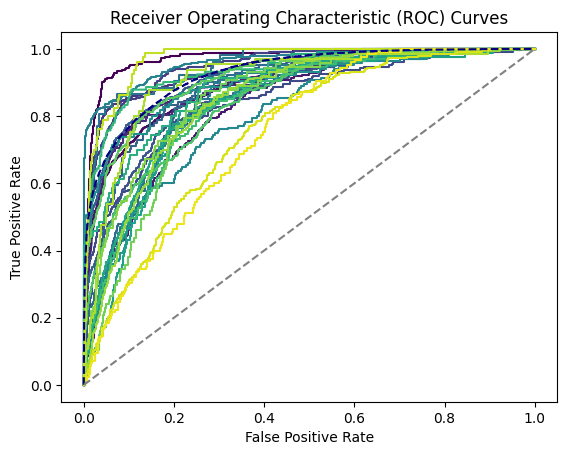

In [24]:
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt

colormap = get_cmap('viridis')
colors = [colormap(i / n_classes) for i in range(n_classes)]  # Dynamically generate colors

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='--', label=f"Macro-average (AUC = {roc_auc['macro']:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.show()

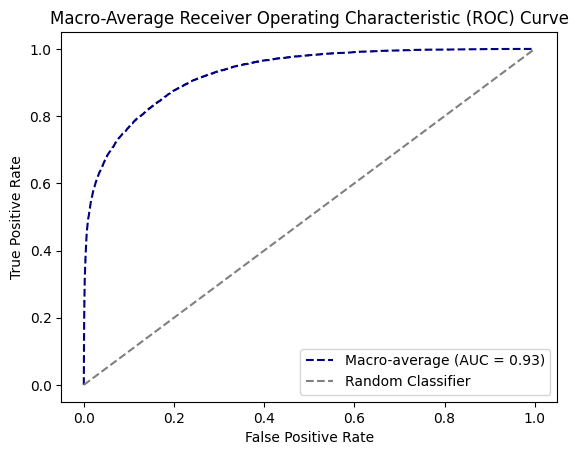

In [25]:
plt.plot(fpr["macro"], tpr["macro"], color='navy', linestyle='--', label=f"Macro-average (AUC = {roc_auc['macro']:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Random Classifier")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-Average Receiver Operating Characteristic (ROC) Curve')

plt.legend(loc="lower right")

plt.show()
